# Using SimpleITK in Python

SimpleITK provides a simplified interface to the ITK library. Most of the commonly used filters have been ported over and this notebook is a simple guide to reading in medical images, displaying them and applying filters


First you need to import numpy, SimpleITK and matplotlib.
This assumes that you have already installed the SimpleITK module into your python distribution - if you get an error message then run pip install to fetch the SimpleITK package.

In [29]:
%matplotlib inline
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
import os

The first step is to read in an image. ITK can handle several 3D fomats as well as simple 2D images.


In [30]:
filename = os.getcwd() + os.sep +"breast_nofs.mha"
im=sitk.ReadImage(str(filename))

The main advantage of using mha, nii etc is that any information about pixel spacing, orientation etc is also handled. It is possible to retrieve this information :

In [31]:
print  'Spacing:',im.GetSpacing()
print  'Size:',im.GetSize()
print  'Direction:',im.GetDirection()
print  'Origin:',im.GetOrigin()

Spacing: (0.8600000143051147, 0.8600000143051147, 3.0)
Size: (256, 256, 84)
Direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Origin: (0.0, 0.0, 0.0)


There is a built in mechanism to display sitk images that uses ImageJ but this requires additional setup. An alternative is to convert the sitk image to a numpy array and then use  matplotlib's imshow command. The sitk.GetArrayFromImage command does this.  

**IMPORTANT: The array indices in sitk and numpy are transposed!**

For example to display the 20th slice in the image you have just loaded:

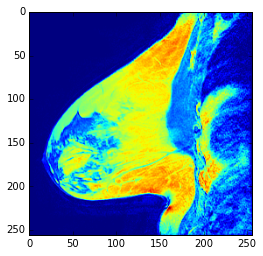

In [32]:
imshow(sitk.GetArrayFromImage(im[:,:,20]))

Or you can convert the whole image into an array and then display the 20th slice of the numpy array: (note change in order of array indices)

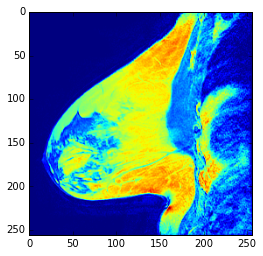

In [33]:
im_array=sitk.GetArrayFromImage(im)
imshow(im_array[20,:,:])

Once you have your image in sitk format you can apply any of the SimpleITK filters. An annotated  list is available at:
 http://erie.nlm.nih.gov/~blowek1/SimpleITK/master/annotated.html. 

###Threshold example

First convert the image to an integer array from 0-255 using the RescaleIntensity procedure (since 0-255 is the default these parameters could have been omitted here). This is not essential but it is easier to demonstrate thresholding if the display range is normalized. 

In [34]:
scaled_im=sitk.RescaleIntensity(im,0,255)

Now apply the threshold filter to the rescaled image. There are 3 parameters here - the lower and upper threshold and the intensity value to set pixels that fall outside the threshold.


In [45]:
threshold1=sitk.Threshold(scaled_im[:,:,20],lower=30,upper=255,outsideValue=0)
threshold2=sitk.Threshold(scaled_im[:,:,20],50,255,100)

<matplotlib.colorbar.Colorbar instance at 0x000000001822EFC8>

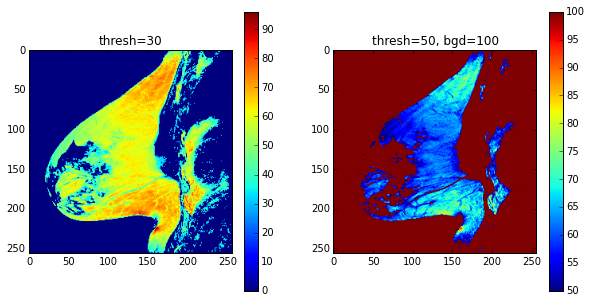

In [46]:
fig=plt.figure(figsize=[10,5])
fig.add_subplot(1,2,1)
imshow(sitk.GetArrayFromImage(threshold1))
plt.title('thresh=30')
plt.colorbar()
fig.add_subplot(1,2,2)
imshow(sitk.GetArrayFromImage(threshold2))
plt.title('thresh=50, bgd=100')
plt.colorbar()

Using the procedural call above assumes that you know the correct parameter names or the correct order. An alternative is to create an image filter as an object. The parameters can then be set individually and the ipython autocomplete will provide a list of available methods. To apply the filter to an image the Execute method is used. This can be very convenient if you want to step through diferent filter settings

In [37]:
thresholdFilter = sitk.ThresholdImageFilter()

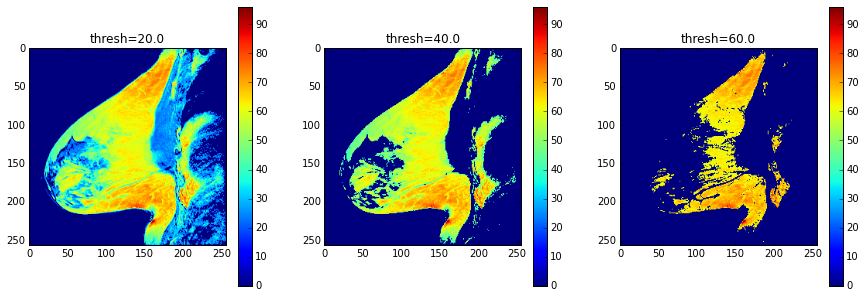

In [38]:
thresholdFilter.SetUpper(255)
thresholdFilter.SetOutsideValue(0)
fig=plt.figure(figsize=[15,5])
for i,thresh in enumerate([20,40,60]):
    fig.add_subplot(1,3,i+1)
    thresholdFilter.SetLower(thresh)
    thresholdIm=thresholdFilter.Execute(scaled_im[:,:,20])
    imshow(sitk.GetArrayFromImage(thresholdIm))
    plt.title('thresh=' + str(thresholdFilter.GetLower()))
    plt.colorbar()


### Resampling to cubic voxels

The example above could have been carried out using numpy calls instead but the SimpleITK filters have advantages when dealing with 3D images. THe spacing is usually taken into account and often the filters are faster than the corresponding numpy or ndarray functions. Resampling to cubic voxels is a common task requiring knowledge of the original pixel size.

The resample image filter requires that the new image spacing and size are set. This snippet will resample an image to cubic voxels and keeps the same field of view.

In [39]:
    resample=sitk.ResampleImageFilter()
    spacingOut = [1.0,1.0,1.0]
    resample.SetOutputSpacing(spacingOut)
    spacingIn=im.GetSpacing()
    shape=im.GetSize()
    newSize=[int(shape[0]*spacingIn[0]/spacingOut[0]), 
            int(shape[1]*spacingIn[1]/spacingOut[1]),
            int(shape[2]*spacingIn[2]/spacingOut[2])]
    resample.SetSize(newSize)
    cube=resample.Execute(im)
    
    print 'size before resampling: ', im.GetSize()
    print 'size after resampling: ', cube.GetSize()
    

size before resampling:  (256, 256, 84)
size after resampling:  (220, 220, 252)


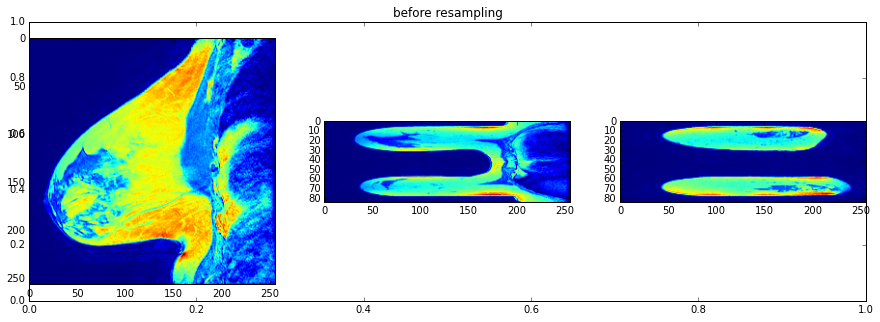

In [40]:
fig=plt.figure(figsize=[15,5])
plt.title('before resampling')
fig.add_subplot(1,3,1)
imshow(sitk.GetArrayFromImage(im[:,:,20]))
fig.add_subplot(1,3,2)
imshow(sitk.GetArrayFromImage(im[:,128,:]))
fig.add_subplot(1,3,3)
imshow(sitk.GetArrayFromImage(im[128,:,:]))

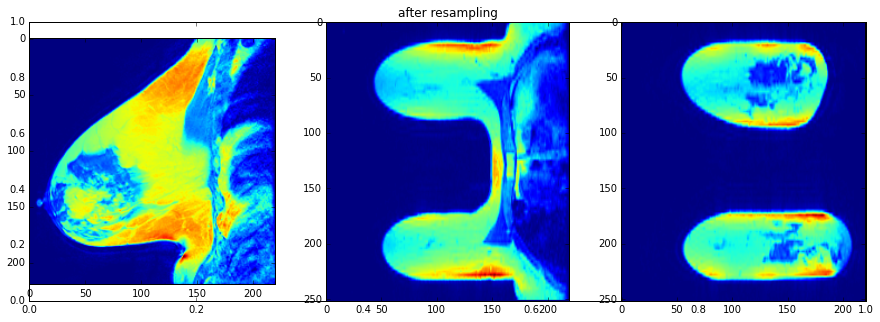

In [41]:
fig=plt.figure(figsize=[15,5])
plt.title('after resampling')
fig.add_subplot(1,3,1)
imshow(sitk.GetArrayFromImage(cube[:,:,55]))
fig.add_subplot(1,3,2)
imshow(sitk.GetArrayFromImage(cube[:,90,:]))
fig.add_subplot(1,3,3)
imshow(sitk.GetArrayFromImage(cube[90,:,:]))